# Fraud Detection w/ Random Forest Example

### load, sample, split data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('fraud_0.csv').sample(10000)

y = df['isFraud']
X = df.drop(columns = ['isFraud'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

del df, X, y, train_test_split

In [2]:
%whos

Variable   Type         Data/Info
---------------------------------
X_test     DataFrame            Unnamed: 0  Trans<...>[2500 rows x 401 columns]
X_train    DataFrame            Unnamed: 0  Trans<...>[7500 rows x 401 columns]
pd         module       <module 'pandas' from '/U<...>ages/pandas/__init__.py'>
y_test     Series       27363     0\n57393     0\<...>ength: 2500, dtype: int64
y_train    Series       115921    0\n11310     0\<...>ength: 7500, dtype: int64


### Random Forest Hyperparams

In [3]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier?

### induce Random Forest

In [4]:
from multiprocessing import cpu_count
n_cores = cpu_count()
n_cores

12

In [5]:
%%time

clf = RandomForestClassifier(max_depth=3, n_estimators=50, random_state=0, n_jobs=n_cores)
clf.fit(X_train, y_train)

CPU times: user 309 ms, sys: 45.1 ms, total: 355 ms
Wall time: 142 ms


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=12,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

### feature importance

https://gist.github.com/WillKoehrsen/475f57ab3c61ea46db0833c6708f1702

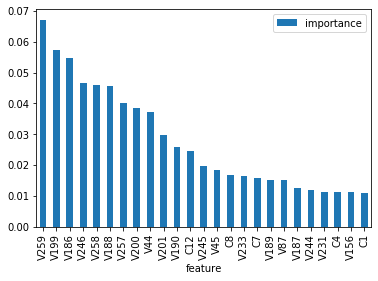

In [6]:
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': clf.feature_importances_}).sort_values('importance', ascending = False)

import matplotlib.pyplot as plt
fi.head(25).plot(x='feature', y='importance', kind='bar')
plt.show()

### test model

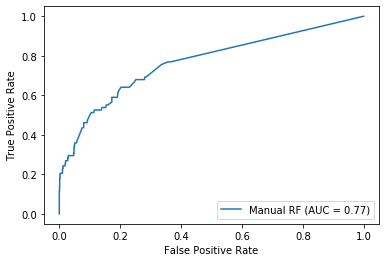

In [7]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn import metrics

auc = metrics.plot_roc_curve(clf, X_test, y_test, name='Manual RF')
plt.show()  

In [8]:
auc.roc_auc

0.7662876622414195

# AutoML :: Random Forest with Optuna
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [9]:
import optuna

In [10]:
RandomForestClassifier?

### objective function

In [11]:
def rf_ojbective(trial):
    
    # Random Forest Params
    n_estimators = trial.suggest_int('n_estimators', 10, 1000)
    criterion = trial.suggest_categorical('criterion', ['gini','entropy'])
    max_depth = trial.suggest_int('max_depth',1,300)
    min_samples_split = trial.suggest_int('min_samples_split',2,20)
    
    # Induction
    clf = RandomForestClassifier(
        n_estimators = n_estimators, 
        criterion = criterion,
        max_depth = max_depth, 
        min_samples_split = min_samples_split,
        n_jobs = n_cores,
        random_state = 0)
    clf.fit(X_train, y_train)
    
    # Test
    fpr, tpr, thresholds = metrics.roc_curve(y_test, [y_hat[1] for y_hat in clf.predict_proba(X_test)], pos_label=1)
    result = 1 - metrics.auc(fpr, tpr)
    return result

### create study backed by PostgreSQL Docker

In [24]:
pg_url = 'postgresql+pg8000://admin@localhost:5433/optuna'
study = optuna.load_study(study_name='rf_ieee_fraud_small', storage=pg_url)

[I 2020-01-21 22:56:31,887] A new study created with name: rf_ieee_fraud_small


In [25]:
%%time
study.optimize(rf_ojbective, n_trials=1000, timeout=600)

[I 2020-01-21 22:56:49,068] Finished trial#0 resulted in value: 0.19844534078638132. Current best value is 0.19844534078638132 with parameters: {'criterion': 'entropy', 'max_depth': 48, 'min_samples_split': 10, 'n_estimators': 946}.
[I 2020-01-21 22:56:52,384] Finished trial#1 resulted in value: 0.209987507675369. Current best value is 0.19844534078638132 with parameters: {'criterion': 'entropy', 'max_depth': 48, 'min_samples_split': 10, 'n_estimators': 946}.
[I 2020-01-21 22:56:56,046] Finished trial#2 resulted in value: 0.20454064240191383. Current best value is 0.19844534078638132 with parameters: {'criterion': 'entropy', 'max_depth': 48, 'min_samples_split': 10, 'n_estimators': 946}.
[I 2020-01-21 22:56:57,851] Finished trial#3 resulted in value: 0.19422124118655915. Current best value is 0.19422124118655915 with parameters: {'criterion': 'entropy', 'max_depth': 146, 'min_samples_split': 11, 'n_estimators': 476}.
[I 2020-01-21 22:57:00,412] Finished trial#4 resulted in value: 0.191

[I 2020-01-21 22:58:03,293] Finished trial#34 resulted in value: 0.20386309259141622. Current best value is 0.18419826801329697 with parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 20, 'n_estimators': 300}.
[I 2020-01-21 22:58:05,214] Finished trial#35 resulted in value: 0.19688380020749952. Current best value is 0.18419826801329697 with parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 20, 'n_estimators': 300}.
[I 2020-01-21 22:58:07,589] Finished trial#36 resulted in value: 0.19134694784983797. Current best value is 0.18419826801329697 with parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 20, 'n_estimators': 300}.
[I 2020-01-21 22:58:09,518] Finished trial#37 resulted in value: 0.19173600965508475. Current best value is 0.18419826801329697 with parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 20, 'n_estimators': 300}.
[I 2020-01-21 22:58:12,405] Finished trial#38 resulted in value: 0.2

[I 2020-01-21 22:59:26,038] Finished trial#68 resulted in value: 0.19046825043934867. Current best value is 0.18419826801329697 with parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 20, 'n_estimators': 300}.
[I 2020-01-21 22:59:28,606] Finished trial#69 resulted in value: 0.19295877532871764. Current best value is 0.18419826801329697 with parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 20, 'n_estimators': 300}.
[I 2020-01-21 22:59:31,224] Finished trial#70 resulted in value: 0.19046825043934867. Current best value is 0.18419826801329697 with parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 20, 'n_estimators': 300}.
[I 2020-01-21 22:59:33,684] Finished trial#71 resulted in value: 0.18364246543437301. Current best value is 0.18364246543437301 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 15, 'n_estimators': 646}.
[I 2020-01-21 22:59:36,055] Finished trial#72 resulted in value: 0.

[I 2020-01-21 23:00:19,768] Finished trial#102 resulted in value: 0.17817972008723448. Current best value is 0.17817972008723448 with parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 10, 'n_estimators': 204}.
[I 2020-01-21 23:00:20,659] Finished trial#103 resulted in value: 0.18396006690804378. Current best value is 0.17817972008723448 with parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 10, 'n_estimators': 204}.
[I 2020-01-21 23:00:21,444] Finished trial#104 resulted in value: 0.20364077155984672. Current best value is 0.17817972008723448 with parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 10, 'n_estimators': 204}.
[I 2020-01-21 23:00:22,433] Finished trial#105 resulted in value: 0.2066579855597197. Current best value is 0.17817972008723448 with parameters: {'criterion': 'entropy', 'max_depth': 12, 'min_samples_split': 10, 'n_estimators': 204}.
[I 2020-01-21 23:00:23,436] Finished trial#106 resulted in va

[I 2020-01-21 23:00:53,202] Finished trial#136 resulted in value: 0.20321730292828555. Current best value is 0.17424146181371614 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 181}.
[I 2020-01-21 23:00:54,032] Finished trial#137 resulted in value: 0.20438184166507867. Current best value is 0.17424146181371614 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 181}.
[I 2020-01-21 23:00:55,373] Finished trial#138 resulted in value: 0.19072497829723267. Current best value is 0.17424146181371614 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 181}.
[I 2020-01-21 23:00:56,323] Finished trial#139 resulted in value: 0.19192127718139274. Current best value is 0.17424146181371614 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 181}.
[I 2020-01-21 23:00:57,119] Finished trial#140 resulted in value

[I 2020-01-21 23:01:32,277] Finished trial#170 resulted in value: 0.19512111202862648. Current best value is 0.17424146181371614 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 181}.
[I 2020-01-21 23:01:33,570] Finished trial#171 resulted in value: 0.18094814626606537. Current best value is 0.17424146181371614 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 181}.
[I 2020-01-21 23:01:34,979] Finished trial#172 resulted in value: 0.17360625886637437. Current best value is 0.17360625886637437 with parameters: {'criterion': 'entropy', 'max_depth': 15, 'min_samples_split': 3, 'n_estimators': 227}.
[I 2020-01-21 23:01:36,148] Finished trial#173 resulted in value: 0.1709436998454339. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:01:37,313] Finished trial#174 resulted in value: 

[I 2020-01-21 23:02:08,690] Finished trial#204 resulted in value: 0.19013741557094166. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:02:09,538] Finished trial#205 resulted in value: 0.27303140019903016. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:02:10,451] Finished trial#206 resulted in value: 0.18400241377119997. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:02:11,394] Finished trial#207 resulted in value: 0.1961718435706875. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:02:12,581] Finished trial#208 resulted in value: 0.1

[I 2020-01-21 23:02:42,468] Finished trial#238 resulted in value: 0.19738931588642572. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:02:43,633] Finished trial#239 resulted in value: 0.18850176798153684. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:02:44,531] Finished trial#240 resulted in value: 0.18585508903427972. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:02:45,683] Finished trial#241 resulted in value: 0.17993182155031873. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:02:46,634] Finished trial#242 resulted in value: 0.

[I 2020-01-21 23:03:19,544] Finished trial#272 resulted in value: 0.1914554616866755. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:03:20,822] Finished trial#273 resulted in value: 0.19457324948654442. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:03:21,977] Finished trial#274 resulted in value: 0.18205445806601872. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:03:22,913] Finished trial#275 resulted in value: 0.2044665353913908. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:03:24,069] Finished trial#276 resulted in value: 0.19

[I 2020-01-21 23:03:54,983] Finished trial#306 resulted in value: 0.2396461919583308. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:03:55,727] Finished trial#307 resulted in value: 0.2680768172097653. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:03:56,657] Finished trial#308 resulted in value: 0.17674522009782112. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:03:57,723] Finished trial#309 resulted in value: 0.1829119820449301. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:03:58,628] Finished trial#310 resulted in value: 0.200

[I 2020-01-21 23:04:25,307] Finished trial#340 resulted in value: 0.1957801350864935. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:04:26,237] Finished trial#341 resulted in value: 0.17858466196616474. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:04:27,157] Finished trial#342 resulted in value: 0.27253117787799874. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:04:27,881] Finished trial#343 resulted in value: 0.1981515594232357. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:04:28,837] Finished trial#344 resulted in value: 0.17

[I 2020-01-21 23:04:55,888] Finished trial#374 resulted in value: 0.1997236867179064. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:04:56,763] Finished trial#375 resulted in value: 0.2007797116178619. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:04:57,703] Finished trial#376 resulted in value: 0.17654936585572423. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:04:58,638] Finished trial#377 resulted in value: 0.18676025323424172. Current best value is 0.1709436998454339 with parameters: {'criterion': 'entropy', 'max_depth': 13, 'min_samples_split': 3, 'n_estimators': 208}.
[I 2020-01-21 23:04:59,569] Finished trial#378 resulted in value: 0.17

[I 2020-01-21 23:05:28,866] Finished trial#408 resulted in value: 0.18326134366596802. Current best value is 0.17062609837176312 with parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 191}.
[I 2020-01-21 23:05:30,018] Finished trial#409 resulted in value: 0.1845740964238074. Current best value is 0.17062609837176312 with parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 191}.
[I 2020-01-21 23:05:30,913] Finished trial#410 resulted in value: 0.1966244256706683. Current best value is 0.17062609837176312 with parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 191}.
[I 2020-01-21 23:05:32,058] Finished trial#411 resulted in value: 0.19380571259183976. Current best value is 0.17062609837176312 with parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 191}.
[I 2020-01-21 23:05:33,218] Finished trial#412 resulted in value: 

[I 2020-01-21 23:06:02,052] Finished trial#442 resulted in value: 0.19493849118126572. Current best value is 0.17062609837176312 with parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 191}.
[I 2020-01-21 23:06:03,219] Finished trial#443 resulted in value: 0.17716604205043507. Current best value is 0.17062609837176312 with parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 191}.
[I 2020-01-21 23:06:04,054] Finished trial#444 resulted in value: 0.18967689343411887. Current best value is 0.17062609837176312 with parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 191}.
[I 2020-01-21 23:06:05,201] Finished trial#445 resulted in value: 0.18583920896059625. Current best value is 0.17062609837176312 with parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 191}.
[I 2020-01-21 23:06:05,967] Finished trial#446 resulted in value

[I 2020-01-21 23:06:39,506] Finished trial#476 resulted in value: 0.27248883101484245. Current best value is 0.17062609837176312 with parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 191}.
[I 2020-01-21 23:06:40,454] Finished trial#477 resulted in value: 0.18778716466577727. Current best value is 0.17062609837176312 with parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 191}.
[I 2020-01-21 23:06:41,521] Finished trial#478 resulted in value: 0.19342988418132923. Current best value is 0.17062609837176312 with parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 191}.
[I 2020-01-21 23:06:42,728] Finished trial#479 resulted in value: 0.19152427533930427. Current best value is 0.17062609837176312 with parameters: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_split': 9, 'n_estimators': 191}.
[I 2020-01-21 23:06:43,569] Finished trial#480 resulted in value

CPU times: user 38min 40s, sys: 1min 31s, total: 40min 12s
Wall time: 10min


In [26]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))
df

,number,value,params_criterion,params_max_depth,params_min_samples_split,params_n_estimators,state
0,0,0.198445,entropy,48,10,946,COMPLETE
1,1,0.209988,gini,278,4,831,COMPLETE
2,2,0.204541,gini,149,18,951,COMPLETE
3,3,0.194221,entropy,146,11,476,COMPLETE
4,4,0.191847,entropy,264,14,669,COMPLETE
...,...,...,...,...,...,...,...
478,478,0.193430,gini,17,5,151,COMPLETE
479,479,0.191524,entropy,29,7,217,COMPLETE
480,480,0.197641,entropy,6,6,165,COMPLETE
481,481,0.183854,entropy,12,3,198,COMPLETE


In [27]:
df.describe()

,number,value,params_max_depth,params_min_samples_split,params_n_estimators
count,483.000000,483.000000,483.000000,483.000000,483.000000
mean,241.000000,0.198419,40.530021,6.538302,257.020704
std,139.574353,0.026246,67.983192,4.619560,190.572417
min,0.000000,0.170626,1.000000,2.000000,16.000000
25%,120.500000,0.184098,9.000000,3.000000,153.000000
50%,241.000000,0.191588,15.000000,5.000000,192.000000
75%,361.500000,0.197986,27.000000,8.000000,246.000000
max,482.000000,0.311395,300.000000,20.000000,992.000000


In [28]:
df['auc'] = 1 - df['value']

In [42]:
df.sort_values(by='auc', ascending=False).head(50)

,number,value,params_criterion,params_max_depth,params_min_samples_split,params_n_estimators,state,auc
401,401,0.170626,entropy,16,9,191,COMPLETE,0.829374
173,173,0.170944,entropy,13,3,208,COMPLETE,0.829056
232,232,0.171240,entropy,13,3,207,COMPLETE,0.828760
257,257,0.171902,entropy,13,3,217,COMPLETE,0.828098
200,200,0.173151,entropy,10,6,122,COMPLETE,0.826849
370,370,0.173294,entropy,10,2,175,COMPLETE,0.826706
181,181,0.173458,entropy,13,3,228,COMPLETE,0.826542
282,282,0.173527,entropy,13,3,191,COMPLETE,0.826473
172,172,0.173606,entropy,15,3,227,COMPLETE,0.826394
302,302,0.173866,entropy,11,2,169,COMPLETE,0.826134


In [44]:
df.sort_values(by='auc', ascending=False).tail(50)

,number,value,params_criterion,params_max_depth,params_min_samples_split,params_n_estimators,state,auc
95,95,0.223539,entropy,2,11,399,COMPLETE,0.776461
81,81,0.223965,entropy,2,11,304,COMPLETE,0.776035
306,306,0.239646,gini,2,2,167,COMPLETE,0.760354
117,117,0.267161,entropy,1,8,153,COMPLETE,0.732839
446,446,0.267278,entropy,1,3,147,COMPLETE,0.732722
336,336,0.267330,entropy,1,2,150,COMPLETE,0.732670
382,382,0.267839,entropy,1,7,102,COMPLETE,0.732161
467,467,0.267841,entropy,1,6,138,COMPLETE,0.732159
228,228,0.267841,entropy,1,7,138,COMPLETE,0.732159
385,385,0.267847,entropy,1,7,139,COMPLETE,0.732153


In [30]:
df['auc'].mean()

0.8015812684744218

In [31]:
df['auc'].max()

0.8293739016282369

In [32]:
df['auc'].min()

0.6886049884604798

### visualizations

In [33]:
optuna.visualization.plot_optimization_history(study)

In [40]:
optuna.visualization.plot_parallel_coordinate(study, params=['n_estimators','max_depth'])

In [38]:
optuna.visualization.plot_contour(study, params=['n_estimators','max_depth'])

In [39]:
optuna.visualization.plot_contour(study, params=['n_estimators','min_samples_split'])